In [57]:
# =========================
# Import Libraries
# =========================

import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import folium
from folium.plugins import HeatMap
from folium.features import DivIcon
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [2]:
# =========================
# Read CSV File
# =========================

df = pd.read_csv('../data/at-dataset/SCATS-data/Scats-Data-Processed.csv')
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

le = LabelEncoder()
df['Direction'] = le.fit_transform(df['Direction'])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [3]:
# =========================
# Sample of DF
# =========================

df.head(5)

,Detector_ID,Lane,Volume,Direction
DateTime,,,,
2023-01-01 00:00:00,2001,1,31,0
2023-01-01 01:00:00,2001,1,47,0
2023-01-01 02:00:00,2001,1,61,0
2023-01-01 03:00:00,2001,1,37,0
2023-01-01 04:00:00,2001,1,33,0


In [4]:
# =========================
# Column Info
# =========================

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7863406 entries, 2023-01-01 00:00:00 to 2025-07-31 23:00:00
Data columns (total 4 columns):
 #   Column       Dtype
---  ------       -----
 0   Detector_ID  int64
 1   Lane         int64
 2   Volume       int64
 3   Direction    int64
dtypes: int64(4)
memory usage: 300.0 MB


In [5]:
# =========================
# Functions for plotting traffic volume for each lane
# =========================

def showFigureEachLaneTraffic(df):
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

# =========================
# Functions for plotting traffic volume for each lane for one week
# =========================

def showFigureEachLaneTrafficForOneWeek(df):
    df = df[(df.index > '2024-10-01') & (df.index <= '2024-10-07')]
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

In [6]:
# =========================
# Set sub_df for training and testing
# =========================

sub_df = df
train = sub_df.loc[sub_df.index < '2024-10-01']
test = sub_df.loc[sub_df.index >= '2024-10-01']

In [7]:
# =========================
# Functions for Feature Creation
# =========================

def create_time_features(df):
    df = df.copy().sort_index()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # # cyclical encodings
    # df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
    # df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)
    # df["sin_dow"]  = np.sin(2*np.pi*df["dayofweek"]/7)
    # df["cos_dow"]  = np.cos(2*np.pi*df["dayofweek"]/7)

    # # ---- LAGS (hourly)
    # # short-term: 1–12h, daily pattern: 24–25h, multi-day & weekly: 48–168h
    # lags = [1, 2, 3, 6, 12, 24, 25, 48, 72, 168]
    # for L in lags:
    #     df[f"lag_{L}"] = df['Volume'].shift(L)

    # # ---- ROLLING STATS (use shift(1) to avoid leakage)
    # # 3h, 6h, 12h, 24h (1d), 168h (1w)
    # wins = {"3h":3, "6h":6, "12h":12, "1d":24, "1w":168}
    # for name, w in wins.items():
    #     past = df['Volume'].shift(1)
    #     df[f"roll_mean_{name}"] = past.rolling(w).mean()
    #     df[f"roll_max_{name}"]  = past.rolling(w).max()
    #     df[f"roll_std_{name}"]  = past.rolling(w).std()

    return df

In [8]:
# =========================
# Create time features
# =========================

sub_df = create_time_features(sub_df)
train = create_time_features(train)
test  = create_time_features(test)
train = train.dropna()
FEATURES = [
    "Detector_ID","Lane","hour","day","dayofweek","month","year","is_weekend","Direction"
    # "sin_hour","cos_hour","sin_dow","cos_dow",
    # "lag_1","lag_2","lag_3","lag_6","lag_12","lag_24","lag_25","lag_48","lag_72","lag_168",
    # "roll_mean_3h","roll_mean_6h","roll_mean_12h","roll_mean_1d","roll_mean_1w",
    # "roll_max_3h","roll_std_3h"
]
TARGET = 'Volume'

In [9]:
# =========================
# Split data into X and y
# =========================

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [10]:
# =========================
# Check info of X_train
# =========================

X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5343718 entries, 2023-01-01 00:00:00 to 2024-09-30 23:00:00
Data columns (total 9 columns):
 #   Column       Dtype
---  ------       -----
 0   Detector_ID  int64
 1   Lane         int64
 2   hour         int32
 3   day          int32
 4   dayofweek    int32
 5   month        int32
 6   year         int32
 7   is_weekend   int64
 8   Direction    int64
dtypes: int32(5), int64(4)
memory usage: 305.8 MB


In [ ]:
# =========================
# Model Training with XGBoost
# =========================

from datetime import datetime

reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",            # or "gpu_hist"
    max_depth=8,
    learning_rate=0.05,
    n_estimators=3000,             # high cap; early stopping trims it
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.2,
    reg_alpha=0.0,
    reg_lambda=2.0,
    random_state=42,
    early_stopping_rounds=50,
    enable_categorical=True,     # uncomment if you cast IDs to category & have new XGB
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_metric="rmse",
    verbose=100
)

# =========================
# save model with date and time
# =========================

model_save_path = f"../models/xgb-model-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.json"
reg.save_model(model_save_path)

In [12]:
# =========================
# Feature Importance of the Model
# =========================

reg = xgb.XGBRegressor()
reg.load_model('../models/xgb-model-v2w.json')
pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_).sort_values(by=0, ascending=False)

,0
Detector_ID,0.229340
hour,0.216238
Lane,0.193287
Direction,0.158523
is_weekend,0.073901
dayofweek,0.048809
year,0.041884
month,0.022923
day,0.015094


In [13]:
# =========================
# Make prediction on the test set
# =========================

test['prediction'] = reg.predict(X_test)

In [14]:
# =========================
# Merge prediction with sub_df
# =========================

prediction_df = sub_df.merge(test[['Detector_ID','Lane', 'prediction']], how='left', left_on=['Detector_ID','Lane', sub_df.index], right_on=['Detector_ID','Lane', test.index])
prediction_df.set_index('key_2', inplace=True)
prediction_df.index.name = 'DateTime'

In [15]:
# =========================
# Function for plotting traffic volume with predictions for one week
# =========================

def showTrafficVolumeWithPredictions(df, detector_id, lane):

    start_date = '2025-07-01'
    end_date = '2025-07-08'

    df = df[(df.index > start_date) & (df.index <= end_date) & (df['Lane'] == lane) & (df['Detector_ID'] == detector_id)] 
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.plot(sub_df.index, sub_df['prediction'], '-', label=f'Predictions Lane {lane}')
        ax.set_title(f'Site {detector_id} - Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

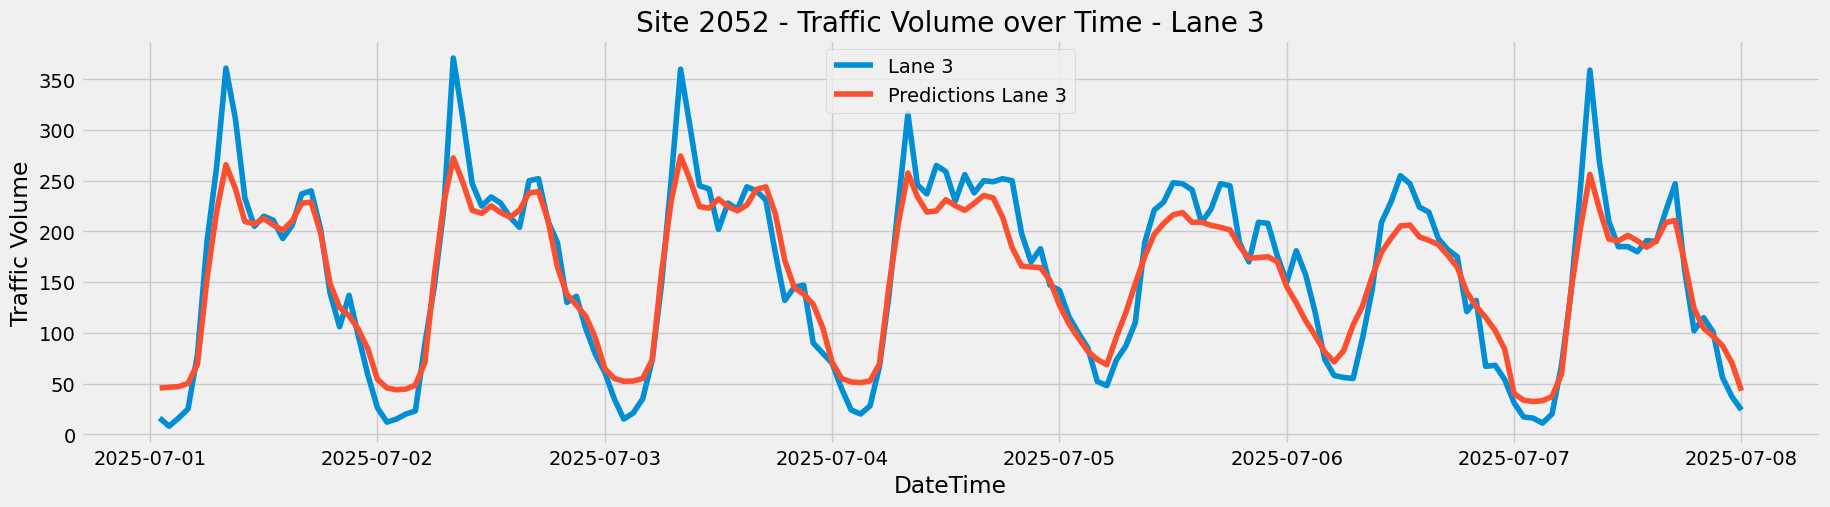

In [16]:
# =========================
# show traffic volume with predictions for one week
# =========================

showTrafficVolumeWithPredictions(prediction_df,2052,3)

In [17]:
# =========================
# Average traffic volume and predictions across all lanes
# =========================

average_traffic = pd.DataFrame()
average_traffic['average_volume'] = prediction_df.groupby(prediction_df.index).mean()['Volume']
average_traffic['average_prediction'] =prediction_df.groupby(prediction_df.index).mean()['prediction']

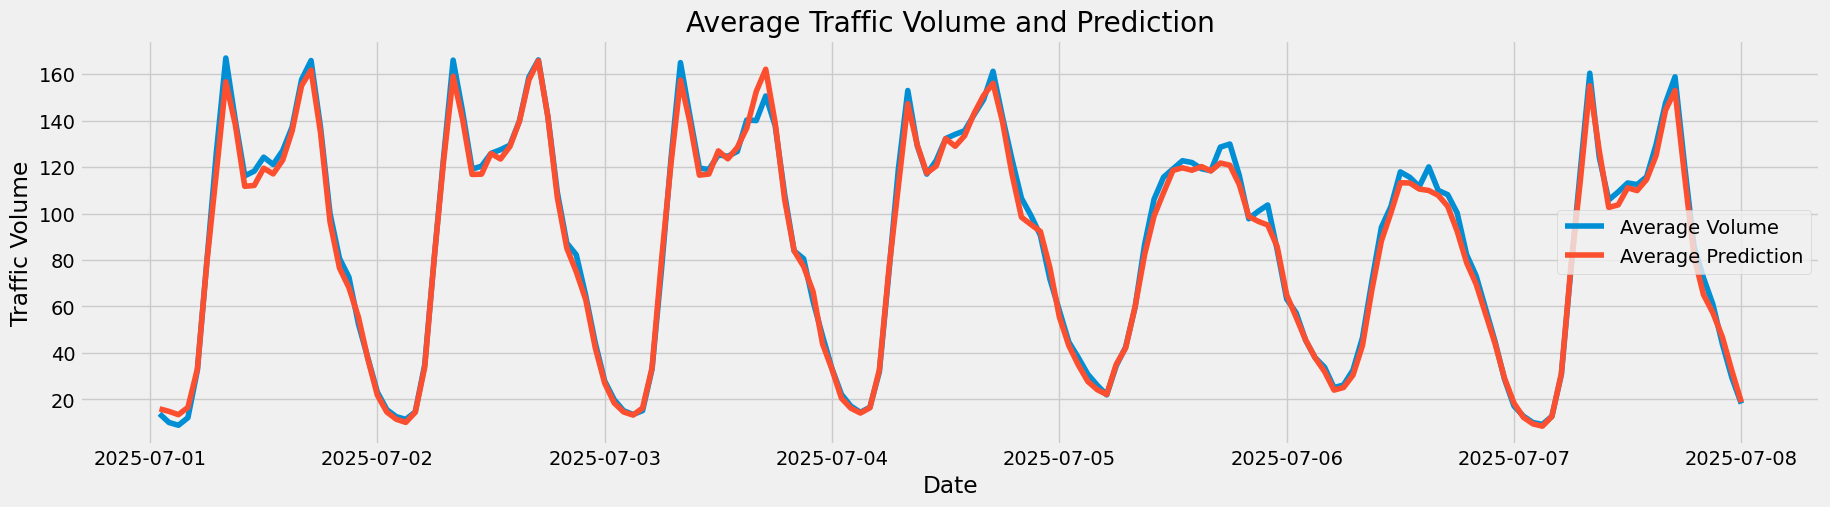

In [18]:
# =========================
# Plot average traffic volume and predictions for one week
# =========================

temp = average_traffic[(average_traffic.index > '2025-07-01') & (average_traffic.index <= '2025-07-08')] 
plt.figure(figsize=(20, 5))
plt.plot(temp.index, temp['average_volume'], label='Average Volume')
plt.plot(temp.index, temp['average_prediction'], label='Average Prediction')
plt.title('Average Traffic Volume and Prediction')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()

In [19]:
# =========================
# Import for SHAP 
# =========================

import shap
# import tqdm as notebook_tqdm

C:\Users\hanju\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# =========================
# create SHAP explainer
# =========================

background = X_train.sample(min(1000, len(X_train)), random_state=42)
explainer = shap.TreeExplainer(reg, feature_perturbation="tree_path_dependent")

# choose a set to explain
X_explain = X_test  # or X_test

# for speed on big sets, sample
X_explain_sample = X_explain.sample(min(5000, len(X_explain)), random_state=42)

# SHAP values: returns array (n_samples, n_features)
shap_values = explainer.shap_values(X_explain_sample)
# Expected value (model base value)
base_value = explainer.expected_value

In [21]:
# =========================
# Base Value of the Model
# =========================

print("Base value:", explainer.expected_value)

Base value: 87.642715


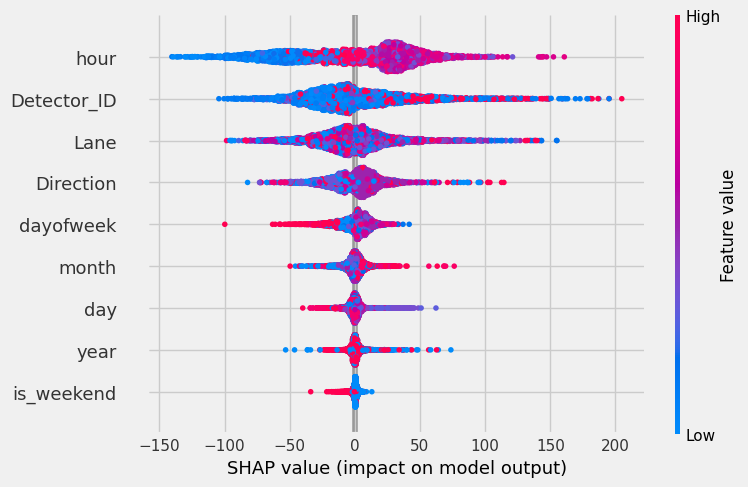

In [22]:
# =========================
# SHAP summary plot
# =========================

shap.summary_plot(shap_values, X_explain_sample, show=True)

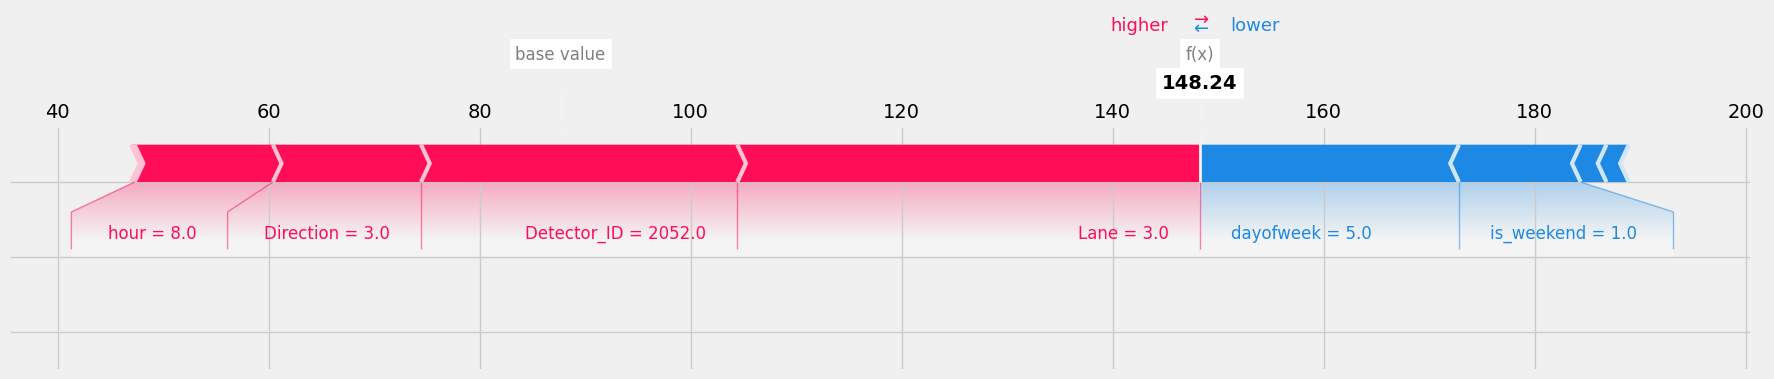

In [23]:
row = X_explain[(X_explain['Lane'] == 3) & (X_explain.index == '2025-07-05 08:00:00') & (X_explain['Detector_ID'] == 2052)]  # replace with your specific row selection

# row = row[selected_features]

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

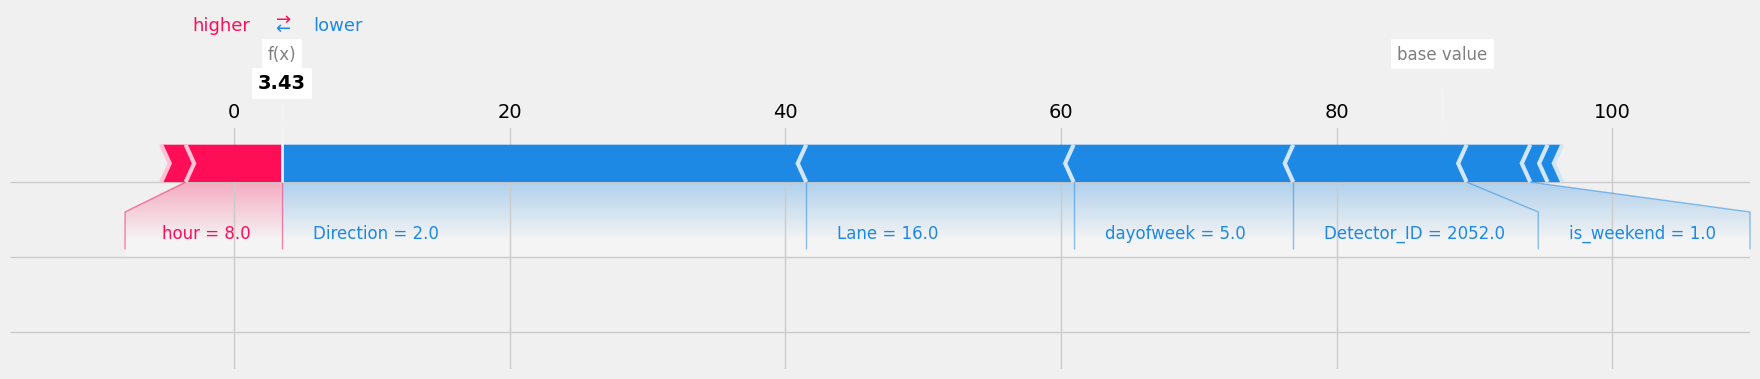

In [24]:
row = X_explain[(X_explain['Lane'] == 16) & (X_explain.index == '2025-07-05 08:00:00') & (X_explain['Detector_ID'] == 2052)]  # replace with your specific row selection

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

In [25]:
test[(test['Lane'] == 3) & (test.index == '2025-07-05 08:00:00') & (test['Detector_ID'] == 2052)]

,Detector_ID,Lane,Volume,Direction,hour,day,dayofweek,month,year,is_weekend,prediction
DateTime,,,,,,,,,,,
2025-07-05 08:00:00,2052,3,110,3,8,5,5,7,2025,1,148.236221


In [26]:
test[(test['Lane'] == 16) & (test.index == '2025-07-05 08:00:00') & (test['Detector_ID'] == 2052)]

,Detector_ID,Lane,Volume,Direction,hour,day,dayofweek,month,year,is_weekend,prediction
DateTime,,,,,,,,,,,
2025-07-05 08:00:00,2052,16,8,2,8,5,5,7,2025,1,3.427979


In [ ]:
# =========================
# function for heatmap generation
# =========================
from pathlib import Path
outdir = Path.cwd().parent / "results" / "heatmap"

def util_color(u):
    if u >= 1.0: return 'red'
    if u >= 0.85: return 'orange'
    if u >= 0.60: return 'yellow'
    return 'green'

m = folium.Map(location=[-36.8485, 174.7633], zoom_start=13, tiles='OpenStreetMap')  # Auckland
n = folium.Map(location=[-36.8485, 174.7633], zoom_start=13, tiles='OpenStreetMap')  # Auckland


def sitemap(df):
    for _, r in df.iterrows():
        folium.CircleMarker(
            location=[r.lat, r.lon],
            radius=6 + 10*min(r.util_95, 1.2),   # scale bubble by utilization
            color=util_color(r.util_95),
            fill=True, fill_opacity=0.8,
            popup=folium.Popup(
                f"Site {r.Detector_ID}<br>"
                f"util_95: {r.util_95:.2f}<br>"
                f"congested_hours: {int(r.congested_hours)}"
            )
        ).add_to(n)

        folium.Marker(
            [r.lat, r.lon],
            icon=DivIcon(
                icon_size=(48, 24),
                icon_anchor=(0, 0),
                html=f"<div style='font-size:11px; font-weight:600; background:rgba(255,255,255,0.7); "
                    f"padding:2px 4px; border-radius:4px;'>{r.Detector_ID}</div>"
            )
        ).add_to(n)
    
    # folium.TileLayer("CartoDB positron").add_to(n)
    folium.TileLayer("CartoDB dark_matter").add_to(n)
    # folium.TileLayer("Stamen Terrain").add_to(n)
    # folium.TileLayer("Stamen Toner").add_to(n)
    # folium.TileLayer("Stamen Watercolor").add_to(n)
    HeatMap(df[['lat','lon','util_95']].values.tolist(), radius=18).add_to(n)
    # folium.LayerControl().add_to(n)
    n.save(outdir / "hotspots_map.html")  # open in browser
    m.save(outdir / "heatmap.html")   # open in browser


In [ ]:
# =========================
# Determine congestion hotspots
# =========================

temp = prediction_df.copy()

# =========================
# Peak hour
# =========================
peak_hours = [7,8,9,15,16,17,18]
temp = temp[temp["hour"].isin(peak_hours)]

group_cols = ["Detector_ID", "hour"]
site_hour = (temp.groupby(group_cols, as_index=False)["Volume"].sum()
               .rename(columns={"Volume":"site_volume"}))

active = (temp.assign(active=lambda x: x["Volume"] > 0)
            .groupby(["Detector_ID","hour"])["active"].sum()
            .reset_index(name="active_lanes"))
eff_lanes = (active.groupby("Detector_ID")["active_lanes"]
             .quantile(0.95).round().clip(lower=1).astype(int)
             .reset_index(name="n_lanes_eff"))

# =========================
# Capacity assumptions
# =========================
per_lane_capacity = 200 
green_ratio = 1
eff_lanes["site_capacity"] = eff_lanes["n_lanes_eff"] * per_lane_capacity * green_ratio

site_hour = site_hour.merge(eff_lanes[["Detector_ID","site_capacity"]], on="Detector_ID", how="left")
site_hour["util"] = site_hour["site_volume"] / site_hour["site_capacity"]

kpi = (site_hour.groupby("Detector_ID")
       .agg(util_95=("util", lambda s: np.quantile(s, 0.95)),
            util_avg=("util", "mean"),
            congested_hours=("util", lambda s: (s >= 0.85).sum()),)
       .reset_index())

def severity(u):
    if u >= 1.0: return "Severe"
    if u >= 0.85: return "High"
    if u >= 0.60: return "Moderate"
    return "Free"
kpi["severity"] = kpi["util_95"].apply(severity)

kpi = kpi.sort_values(["util_95","congested_hours"], ascending=[False, False]).reset_index(drop=True)
kpi["rank"] = np.arange(1, len(kpi)+1)

# =========================
# Merger with site coordinates
# =========================
site_coordinates = pd.read_csv('../data/at-dataset/SCATS-data/Site-List-Coordinates.csv', usecols=['Detector_ID', 'Latitude', 'Longitude'])
kpi[['lat','lon']] = site_coordinates.set_index('Detector_ID').loc[kpi['Detector_ID']].values

kpi[["rank","Detector_ID","util_95","util_avg","congested_hours","severity","lat","lon"]].head(10)

# =========================
# Print heatmap
# =========================
sitemap(kpi)

In [56]:
kpi[["rank","Detector_ID","util_avg","severity","lat","lon"]].head(10)

,rank,Detector_ID,util_avg,severity,lat,lon
0,1,2906,1.220838,Severe,-36.847762,174.783436
1,2,2905,1.009348,Severe,-36.850865,174.775229
2,3,2025,0.885252,Severe,-36.849840,174.760852
3,4,2118,0.912585,Severe,-36.848077,174.753028
4,5,2097,0.808090,Severe,-36.851654,174.759911
5,6,2909,0.822728,Severe,-36.854055,174.758360
6,7,2098,0.869178,High,-36.851263,174.758516
7,8,2902,0.912455,High,-36.853723,174.757403
8,9,2099,0.835867,High,-36.849394,174.759307
9,10,2001,0.763353,High,-36.844356,174.765339


In [29]:
# =========================
# Most congested sites
# =========================

most_congested = prediction_df[prediction_df['Detector_ID'].isin(kpi['Detector_ID'].head(3))]
most_congested["Detector_ID"].unique()

array([2906, 2905, 2025])